In [21]:
import pandas as pd
import numpy as np 
import pickle 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


# tss code information of WSIs
all_data = pd.read_excel("tissue_source_site_data.xlsx", index_col=0)


# Clean medical center names
all_data.medical_center = all_data.medical_center.replace("Mayo Clinic Rochester", "Mayo Clinic")
all_data.medical_center = all_data.medical_center.replace("Case Western - St Joes", "Case Western")

all_data = all_data.replace({'ABS - IUPUI' : 'ABS IUPUI',
                             'University Of Michigan' : 'University of Michigan'})


from helpers import overview_generator, overview_generator_mc, return_top, return_bottom

overview_generator(all_data).head()

,Number of WSIs,Number of Contributing Medical Centers,Medical Centers
TCGA-BRCA,1029,38,"[Mayo Clinic, University of Pittsburgh, Boston..."
TCGA-GBM,856,14,"[Duke University, Henry Ford Hospital, Mayo Cl..."
TCGA-LGG,705,23,"[The University of New South Wales, Case Weste..."
TCGA-THCA,510,21,"[MD Anderson, Memorial Sloan Kettering Cancer ..."
TCGA-KIRC,506,17,"[University of North Carolina, NCI Urologic On..."


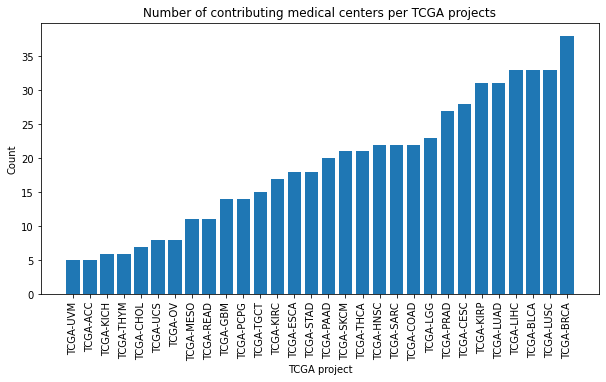

In [23]:
plt.figure(figsize=(10,5))

ov = overview_generator(all_data)
ov = ov.sort_values("Number of Contributing Medical Centers")
plt.bar(x = ov.index, height = ov["Number of Contributing Medical Centers"])
plt.xticks(rotation = 90)
plt.title("Number of contributing medical centers per TCGA projects")
plt.ylabel("Count")
plt.xlabel("TCGA project")
plt.show()

## Get medical centers that contributed for more than 1% of all WSIs.

In [25]:
from helpers import return_top

return_top(all_data, 0.01).medical_center.value_counts()

MD Anderson                               619
Memorial Sloan Kettering Cancer Center    548
University of Pittsburgh                  492
International Genomics Consortium         428
Indivumed                                 407
Asterand                                  405
Mayo Clinic                               397
Henry Ford Hospital                       349
Case Western                              326
Duke University                           264
University of Michigan                    258
Roswell Park                              243
Christiana Healthcare                     231
University of North Carolina              221
Greater Poland Cancer Center              185
ILSbio                                    180
Johns Hopkins                             178
University Health Network                 155
Erasmus MC                                155
University of California San Francisco    142
Barretos Cancer Hospital                  124
Emory University                  

In [244]:
projects = ["TCGA-BRCA", "TCGA-LUSC", "TCGA-PRAD", "TCGA-KIRC", "TCGA-THCA"]

x = return_top(all_data, 0.01)

xo = x[~x.project_id.isin(projects)]
xo.project_id = "other"

x = x[x.project_id.isin(projects)]
x = x.groupby(["medical_center", "project_id"]).count().iloc[:,0]
x = x.reset_index()
x = x.rename({"slide_name" : "count"}, axis = "columns")

xo = xo.groupby(["medical_center", "project_id"]).count().iloc[:,0]
xo = xo.reset_index()
xo = xo.rename({"slide_name" : "count"}, axis = "columns")

x = pd.concat([x, xo], axis = 0).reset_index(drop = True)

C:\Users\taher\Anaconda3\envs\tf\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [226]:
accs =  {'Memorial Sloan Kettering Cancer Center': 'MSKCC',
         'International Genomics Consortium': 'IGC',
         'University of Michigan':'UMich',
         'University of North Carolina': 'UNC',
         'Greater Poland Cancer Center': "GPCC",
         'University Health Network': 'UHN',
         'University of California San Francisco': 'UCSF',
         'University of Pittsburgh': 'Pitt',
         'Barretos Cancer Hospital': 'BCH',
         'Henry Ford Hospital': 'HFH',
         'Christiana Healthcare': 'Christiana HC',
         'Emory University': 'Emory U',
         'Duke University': 'Duke U'}

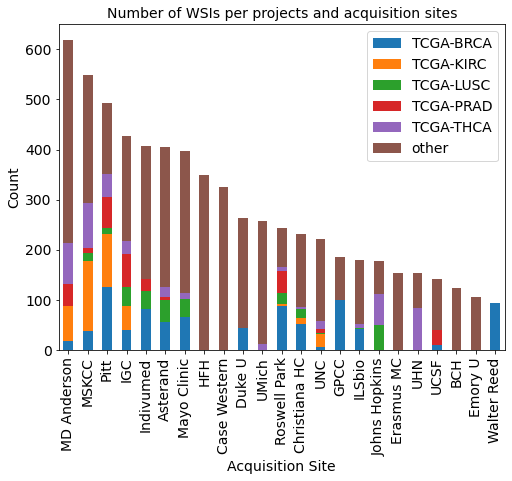

In [245]:
x_pivot =  x.pivot(index = "medical_center", columns= "project_id", values= "count")
x_pivot = x_pivot.loc[x_pivot.sum(axis = 1).sort_values(ascending = False).index]
x_pivot = x_pivot.rename(accs)
    
ax = x_pivot.plot(kind = "bar", stacked = True, figsize = (8,6), fontsize = 14)
plt.legend(fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.xlabel("Acquisition Site", fontsize = 14)
plt.title("Number of WSIs per projects and acquisition sites", fontsize = 14)
ax.figure.savefig("distribution.pdf", bbox_inches='tight', dpi = 900)

# DenseNet & KimiaNet deep features

In [251]:
all_patches_kimia = pd.read_pickle("all_patches_kimia_merged.pkl")
all_patches_dense = pd.read_pickle("all_patches_dense_merged.pkl")


all_patches_kimia.head()

,slide_name,patient_id,primary_diagnosis,morphology,tissue_or_organ_of_origin,site_of_resection_or_biopsy,tumor_stage,primary_site,disease_type,project_id,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,TCGA-B8-5164-01Z-00-DX1.6d846ab5-2fcf-4a99-8b8...,TCGA-B8-5164,"Clear cell adenocarcinoma, NOS",8310/3,"Kidney, NOS","Kidney, NOS",stage iii,Kidney,Kidney Renal Clear Cell Carcinoma,TCGA-KIRC,...,5.422207,7.137179,-2.729575,6.476495,2.905410,1.835965,-1.702069,-2.964120,4.894524,-1.698124
1,TCGA-B8-5164-01Z-00-DX1.6d846ab5-2fcf-4a99-8b8...,TCGA-B8-5164,"Clear cell adenocarcinoma, NOS",8310/3,"Kidney, NOS","Kidney, NOS",stage iii,Kidney,Kidney Renal Clear Cell Carcinoma,TCGA-KIRC,...,5.704861,7.426342,-2.994546,6.756467,2.892704,2.652586,-2.665814,-4.752261,3.060353,-1.684969
2,TCGA-B8-5164-01Z-00-DX1.6d846ab5-2fcf-4a99-8b8...,TCGA-B8-5164,"Clear cell adenocarcinoma, NOS",8310/3,"Kidney, NOS","Kidney, NOS",stage iii,Kidney,Kidney Renal Clear Cell Carcinoma,TCGA-KIRC,...,5.135601,5.395135,-1.909677,3.949593,1.534538,1.444817,-1.921691,-3.054786,1.690774,-1.161527
3,TCGA-B8-5164-01Z-00-DX1.6d846ab5-2fcf-4a99-8b8...,TCGA-B8-5164,"Clear cell adenocarcinoma, NOS",8310/3,"Kidney, NOS","Kidney, NOS",stage iii,Kidney,Kidney Renal Clear Cell Carcinoma,TCGA-KIRC,...,6.005867,8.066545,-4.896879,6.698669,5.004799,4.263371,-2.102757,-3.530324,3.355356,-3.026355
4,TCGA-B8-5164-01Z-00-DX1.6d846ab5-2fcf-4a99-8b8...,TCGA-B8-5164,"Clear cell adenocarcinoma, NOS",8310/3,"Kidney, NOS","Kidney, NOS",stage iii,Kidney,Kidney Renal Clear Cell Carcinoma,TCGA-KIRC,...,4.946968,8.031289,-3.954801,8.052020,2.598181,4.312536,-3.598509,-7.538970,3.959731,-3.679186


## Here we define a function that create a simple neural networks with two hidden dense layers

This network will be trained to classify acquisition sites from deep features. 

In [247]:
def create_ann(output_shape):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer((1024,)))
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    model.add(tf.keras.layers.Dense(200, activation='relu'))
    model.add(tf.keras.layers.Dense(output_shape, activation = "softmax"))

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])
    
    return model

create_ann(output_shape=20).summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 500)               512500    
_________________________________________________________________
dense_3 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_4 (Dense)              (None, 20)                4020      
Total params: 616,720
Trainable params: 616,720
Non-trainable params: 0
_________________________________________________________________


In [253]:
def create_test_train(data, mcs,):
    
    centers = mcs.medical_center.unique()
    
    #finding patients with on;y one WSIs, they are going to be used to test trained models
    patient_ids = mcs.slide_name.apply(lambda x: x[:12])
    one_sample_ids = patient_ids.value_counts()[patient_ids.value_counts() == 1].index.values

    data = data[data.medical_center.isin(centers)]    
    
    train_ids, test_ids = train_test_split(one_sample_ids, test_size=0.2)

    x_train = data[~data.patient_id.isin(test_ids)]
    x_test = data[data.patient_id.isin(test_ids)]

    le = preprocessing.LabelEncoder()
    y = le.fit_transform(data.medical_center)

    y_train = y[~data.patient_id.isin(test_ids)]
    y_test = y[data.patient_id.isin(test_ids)]
    
    return data, x_train, y_train, x_test, y_test, le


## DenseNet Features for hospitals with more than 1%

In [255]:
from helpers import overview_generator, overview_generator_mc, return_top, return_bottom

data = all_patches_dense
data = data.sample(frac=1).reset_index(drop=True)

mcs = return_top(all_data, 0.01)

data, x_train, y_train, x_test, y_test, le = create_test_train(data, mcs)


output_shape = np.unique(data.medical_center).shape[0]


model = create_ann(output_shape)
model.fit(x_train.iloc[:,13:], y_train, epochs=5, validation_split = 0.1, batch_size = 50, shuffle=True)    

Epoch 1/5
4784/4784 [==============================] - 11s 2ms/step - loss: 1.0488 - accuracy: 0.6815 - val_loss: 0.7618 - val_accuracy: 0.7601
Epoch 2/5
4784/4784 [==============================] - 10s 2ms/step - loss: 0.6055 - accuracy: 0.8110 - val_loss: 0.5775 - val_accuracy: 0.8171
Epoch 3/5
4784/4784 [==============================] - 10s 2ms/step - loss: 0.4736 - accuracy: 0.8505 - val_loss: 0.4304 - val_accuracy: 0.8667
Epoch 4/5
4784/4784 [==============================] - 10s 2ms/step - loss: 0.3989 - accuracy: 0.8731 - val_loss: 0.4267 - val_accuracy: 0.8653
Epoch 5/5
4784/4784 [==============================] - 10s 2ms/step - loss: 0.3516 - accuracy: 0.8873 - val_loss: 0.4215 - val_accuracy: 0.8666


In [259]:
preds = model.predict_classes(x_test.iloc[:,13:])
preds = le.inverse_transform(preds)
trues = le.inverse_transform(y_test)

cr = classification_report(trues, preds, output_dict=True, zero_division=False)  
cr = pd.DataFrame(cr).transpose()
np.round(cr, 2)

C:\Users\taher\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,precision,recall,f1-score,support
Asterand,0.80,0.80,0.80,4679.00
Barretos Cancer Hospital,0.58,0.73,0.65,714.00
Case Western,0.81,0.70,0.75,1211.00
Christiana Healthcare,0.67,0.31,0.42,618.00
Duke University,0.65,0.45,0.53,693.00
Emory University,0.41,0.20,0.27,218.00
Erasmus MC,0.81,0.60,0.69,1333.00
Greater Poland Cancer Center,0.37,0.76,0.50,327.00
Henry Ford Hospital,0.27,0.62,0.38,72.00
ILSbio,0.84,0.85,0.85,1612.00


## KimiaNet Features for hospitals with more than 1%

As you can see, the model trained on KimiaNet features classifies acquisition sites more accurately (~16%). This finding suggests that KimiaNet learned to distinguish acquisition sites during its training phase. 

In [260]:
data = all_patches_kimia
data = data.sample(frac=1).reset_index(drop=True)

mcs = return_top(all_data, 0.01)

data, x_train, y_train, x_test, y_test, le = create_test_train(data, mcs)


output_shape = np.unique(data.medical_center).shape[0]


model = create_ann(output_shape)
model.fit(x_train.iloc[:,13:], y_train, epochs=5, validation_split = 0.1, batch_size = 50, shuffle=True)    

Epoch 1/5
4825/4825 [==============================] - 11s 2ms/step - loss: 0.2850 - accuracy: 0.9138 - val_loss: 0.1692 - val_accuracy: 0.9489
Epoch 2/5
4825/4825 [==============================] - 10s 2ms/step - loss: 0.1330 - accuracy: 0.9588 - val_loss: 0.1319 - val_accuracy: 0.9608
Epoch 3/5
4825/4825 [==============================] - 10s 2ms/step - loss: 0.1016 - accuracy: 0.9689 - val_loss: 0.1203 - val_accuracy: 0.9667
Epoch 4/5
4825/4825 [==============================] - 10s 2ms/step - loss: 0.0881 - accuracy: 0.9742 - val_loss: 0.1176 - val_accuracy: 0.9672
Epoch 5/5
4825/4825 [==============================] - 10s 2ms/step - loss: 0.0757 - accuracy: 0.9782 - val_loss: 0.1218 - val_accuracy: 0.9696


In [261]:
preds = model.predict_classes(x_test.iloc[:,13:])
preds = le.inverse_transform(preds)
trues = le.inverse_transform(y_test)

cr = classification_report(trues, preds, output_dict=True, zero_division=False)  
cr = pd.DataFrame(cr).transpose()
np.round(cr, 2)

C:\Users\taher\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,precision,recall,f1-score,support
Asterand,0.95,0.92,0.93,5580.00
Barretos Cancer Hospital,0.91,0.91,0.91,1238.00
Case Western,0.84,0.90,0.87,706.00
Christiana Healthcare,0.95,0.41,0.57,685.00
Duke University,0.68,0.26,0.38,570.00
Emory University,0.00,0.00,0.00,0.00
Erasmus MC,0.86,0.97,0.91,796.00
Greater Poland Cancer Center,0.63,0.75,0.69,244.00
Henry Ford Hospital,0.79,0.79,0.79,157.00
ILSbio,0.92,0.78,0.84,1691.00


The same logic was used for the other experiments mentiend in the paper. 